<a href="https://colab.research.google.com/github/alenabozny/context-augmentation/blob/master/LIWC_LR_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount Google Drive to the Notebook. This allows us to load datasets that are copyied to the GD directory.**


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5SpHKAWj3rHllHUiMoM6rp2PzmoyJfyV8lsFThkyzBsN0Z-TcWw1Q
Mounted at /content/drive


**Load the dataset (LIWC features for CRED/NONCRED data)**

In [2]:
import pandas as pd
import numpy as np

liwc_data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/LIWC_paragrafy.csv", sep=";",decimal=',', header=0)

liwc_data.head()

,Body,Rate,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,function,pronoun,ppron,i,we,you,shehe,they,ipron,article,prep,auxverb,adverb,conj,negate,verb,adj,compare,interrog,number,quant,affect,posemo,negemo,anx,anger,sad,social,family,friend,...,health,sexual,ingest,drives,affiliation,achieve,power,reward,risk,focuspast,focuspresent,focusfuture,relativ,motion,space,time,work,leisure,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler,AllPunc,Period,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,Statins available in the United States include...,CRED,56,98.29,76.25,2.24,25.77,18.67,33.93,60.71,33.93,7.14,5.36,0.0,1.79,0.0,0.0,3.57,1.79,7.14,14.29,3.57,0.00,1.79,0.0,8.93,7.14,5.36,0.00,5.36,3.57,0.00,0.00,0.00,0.00,0.00,0.0,7.14,0.0,0.0,...,5.36,0.0,0.00,5.36,1.79,1.79,0.00,1.79,0.00,1.79,8.93,0.0,7.14,0.00,5.36,0.00,1.79,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0,44.64,8.93,10.71,0.0,0.0,0.0,0.0,0.00,0.00,0.00,25.00,0.00
1,Statins are one of the most common medicines p...,CRED,53,93.26,93.42,5.35,61.55,17.67,13.21,92.45,50.94,15.09,9.43,0.0,5.66,0.0,0.0,3.77,5.66,7.55,20.75,5.66,3.77,3.77,0.0,15.09,11.32,9.43,0.00,5.66,3.77,1.89,1.89,0.00,0.00,0.00,0.0,11.32,0.0,0.0,...,9.43,0.0,1.89,11.32,5.66,1.89,0.00,3.77,0.00,1.89,11.32,0.0,9.43,0.00,7.55,0.00,1.89,0.0,0.0,0.0,0.0,0.0,3.77,0.0,1.89,1.89,1.89,0,20.75,11.32,7.55,0.0,0.0,0.0,0.0,0.00,0.00,1.89,0.00,0.00
2,They work on an enzyme that is used by our bod...,CRED,84,74.10,90.47,6.50,25.77,21.00,17.86,94.05,50.00,13.10,7.14,0.0,5.95,0.0,0.0,1.19,5.95,5.95,15.48,7.14,3.57,9.52,0.0,13.10,4.76,3.57,0.00,0.00,1.19,4.76,2.38,2.38,1.19,1.19,0.0,9.52,0.0,0.0,...,13.10,0.0,1.19,14.29,5.95,2.38,3.57,1.19,1.19,1.19,10.71,0.0,9.52,0.00,8.33,1.19,2.38,0.0,0.0,0.0,0.0,0.0,2.38,0.0,1.19,1.19,1.19,0,16.67,5.95,8.33,0.0,0.0,0.0,0.0,0.00,0.00,2.38,0.00,0.00
3,"Yep, that’s right…our bodies make cholesterol,...",CRED,76,64.39,85.38,19.27,25.77,19.00,19.74,93.42,50.00,11.84,5.26,0.0,5.26,0.0,0.0,0.00,6.58,5.26,14.47,7.89,5.26,10.53,0.0,11.84,5.26,3.95,2.63,0.00,1.32,5.26,2.63,2.63,1.32,1.32,0.0,7.89,0.0,0.0,...,13.16,0.0,1.32,13.16,5.26,1.32,3.95,1.32,1.32,0.00,9.21,0.0,13.16,1.32,10.53,1.32,1.32,0.0,0.0,0.0,0.0,0.0,2.63,0.0,1.32,1.32,1.32,0,18.42,6.58,9.21,0.0,0.0,0.0,0.0,0.00,0.00,2.63,0.00,0.00
4,That’s because cholesterol is vital for our su...,CRED,101,92.29,61.69,29.80,1.00,25.25,18.81,83.17,43.56,5.94,1.98,0.0,1.98,0.0,0.0,0.00,3.96,7.92,14.85,4.95,3.96,8.91,0.0,6.93,4.95,2.97,1.98,2.97,0.99,5.94,0.99,4.95,1.98,1.98,0.0,3.96,0.0,0.0,...,10.89,0.0,0.00,10.89,1.98,0.99,4.95,0.00,2.97,0.99,4.95,0.0,13.86,0.99,8.91,3.96,1.98,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.00,0,20.79,3.96,3.96,0.0,0.0,0.0,0.0,0.99,1.98,0.99,5.94,2.97


In [3]:
liwc_data_paragraphs = liwc_data[0:1917:3]

def y_to_binary(Y):
  def label_to_0_1(lbl):
    if lbl=='CRED':
      return 1
    else:
      return 0

  Y_mapped = map(label_to_0_1, Y)
  return np.array(list(Y_mapped))

In [4]:
np.shape(liwc_data_paragraphs)

(639, 95)

## **Build and test LR model on the reduced dataset (only the most important features)**

In [ ]:
from sklearn.utils import shuffle
shuffle(liwc_data[important_features]).head()

,function,pronoun,i,we,you,shehe,they,ipron,article,prep,auxverb,conj,compare,interrog,affect,posemo,negemo,anx,sad,family,friend,female,male,cause,certain,differ,percept,see,hear,feel,sexual,drives,affiliation,power,reward,risk,focusfuture,leisure,home,money,informal,swear,assent,nonflu,Period,SemiC,QMark,Exclam,Dash,Apostro
1050,54.76,9.52,0.00,0.0,0.00,0.0,2.38,7.14,9.52,7.14,11.90,7.14,4.76,0.00,7.14,2.38,4.76,0.00,0.00,0.0,0.0,0.0,0.0,0.00,4.76,14.29,0.00,0.0,0.00,0.0,0.0,7.14,0.00,2.38,0.00,4.76,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,7.14,0.0,0.0,0.0,0.00,0.00
525,42.31,5.77,0.00,0.0,5.77,0.0,0.00,0.00,9.62,13.46,7.69,3.85,1.92,0.00,3.85,0.00,3.85,1.92,1.92,0.0,0.0,0.0,0.0,5.77,0.00,1.92,1.92,0.0,1.92,0.0,0.0,5.77,0.00,3.85,0.00,1.92,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,5.77,0.0,0.0,0.0,1.92,0.00
1791,48.57,22.86,0.00,0.0,11.43,0.0,0.00,11.43,0.00,17.14,2.86,5.71,5.71,2.86,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,5.71,0.00,2.86,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,2.86,0.0,0.0,0.0,0.0,8.57,0.0,0.0,0.0,0.00,0.00
279,44.83,8.05,3.45,0.0,0.00,0.0,2.30,2.30,8.05,14.94,3.45,4.60,2.30,2.30,4.60,2.30,2.30,0.00,1.15,0.0,0.0,0.0,0.0,2.30,2.30,2.30,0.00,0.0,0.00,0.0,0.0,8.05,1.15,5.75,1.15,0.00,0.00,1.15,0.0,0.00,0.0,0.0,0.0,0.0,4.60,0.0,0.0,0.0,3.45,1.15
291,45.24,7.14,0.00,0.0,4.76,0.0,0.00,2.38,11.90,11.90,9.52,4.76,4.76,0.00,2.38,0.00,2.38,2.38,0.00,0.0,0.0,0.0,0.0,2.38,0.00,2.38,2.38,0.0,0.00,0.0,0.0,11.90,0.00,11.90,0.00,2.38,2.38,0.00,0.0,0.00,0.0,0.0,0.0,0.0,7.14,0.0,0.0,0.0,0.00,2.38


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing as p


VALIDATION_SPLIT = 0.2

def build_logit(liwc_data, important_features):
  # split the data into a training set and a validation set
  min_max_scaler = p.MinMaxScaler()
  liwc_shuffled = shuffle(liwc_data)
  X = liwc_shuffled[important_features].values[:, 2:]
  X = min_max_scaler.fit_transform(X)
  Y = liwc_shuffled.values[:,1]
  Y = y_to_binary(Y)

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT)
  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)

  y_pred = logreg.predict(X_test)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
  print('F1: {:.2f}'.format(metrics.f1_score(y_test, y_pred, average='weighted')))
  # return logreg.score(X_test, y_test)
  return (metrics.f1_score(y_test, y_pred, average='weighted'), y_test, y_pred)

f1, y_test, y_pred = build_logit(liwc_data, important_features)

Accuracy of logistic regression classifier on test set: 0.74
F1: 0.73


 **For N iterations check how important feature addition affects the mean accuracy of the model.**

In [ ]:
import matplotlib.pyplot as plt

N = 90

mean_f1 = []

for i in range(3, N, 9):
  print('Num features: %i' %i)
  important_features = get_n_most_important(i)
  f1, _, _ = build_logit(liwc_data, important_features)
  # mean_accuracies.append(acc)
  mean_f1.append(f1)


Num features: 3


KeyboardInterrupt: ignored

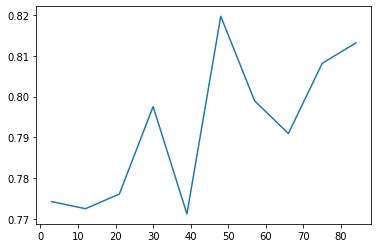

In [ ]:
plt.figure()
plt.plot(range(3, N, 9),mean_f1, label='F1 change by number of features in LogisticRegression model')
plt.show()

In [9]:
!pip install spacytextblob

     |████████████████████████████████| 10.4MB 474kB/s 
     |████████████████████████████████| 1.1MB 49.4MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


# The Model
Features:
- TFIDF
- NER
- POS
- LIWC
- sentiment

In [5]:
from sklearn.pipeline import Pipeline
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing as p

VALIDATION_SPLIT = 0.1

data = liwc_data_paragraphs
Y = data['Rate']
Y = y_to_binary(Y)

np.shape(Y)

(639,)

### **TFIDF**

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk

nltk.download('punkt')

from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize

corpus = data['Body']
corpus_removed_numbers = [re.sub(r'\d+', '', s) for s in corpus]

corpus_tokenized = []
stemmer= PorterStemmer()

for s in corpus_removed_numbers:
  tokens = word_tokenize(s)
  stemmed_tokens = [stemmer.stem(word) for word in tokens]
  corpus_tokenized.append(" ".join(stemmed_tokens))

vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus_tokenized)
X_tfidf = np.array(X_tfidf.toarray())

np.shape(X_tfidf)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(639, 3352)

### **LIWC**

In [7]:
# important_features = get_n_most_important(50)
X_liwc = data.values[:, 2:]

np.shape(X_liwc)

(639, 93)

### **Sentiment**

In [10]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
spacy_text_blob = SpacyTextBlob()
nlp.add_pipe(spacy_text_blob)

X_sentiment = []
for s in corpus:
  doc = nlp(s)
  X_sentiment.append([doc._.sentiment.polarity,
                     doc._.sentiment.subjectivity]
                     )
np.shape(X_sentiment)

(639, 2)

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

import sklearn.preprocessing as p

min_max_scaler = p.MinMaxScaler()
X = np.concatenate((X_tfidf, X_liwc, X_sentiment), axis=1)
X = min_max_scaler.fit_transform(X)

def eval_and_print_metrics(clf, X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print("F1 score on test set: "
          # "%0.3f" % metrics.f1_score(y_test, y_pred, average='weighted'))
    # print("-" * 10)
    return metrics.f1_score(y_test, y_pred, average='weighted')

# clf = MLPClassifier(max_iter=3000, solver='adam', hidden_layer_sizes=(50,20)).fit(X_train, y_train)
clf = LogisticRegression()

f1s = []
for i in range(0,20):
  f1s.append(eval_and_print_metrics(clf, X, Y))

print("Mean weighted f1: ", np.mean(f1s), " STD: ", np.std(f1s))

Mean weighted f1:  0.7173579812165677  STD:  0.0622704551327901


In [16]:
np.shape(X)

(639, 3447)

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def fit_logreg_and_show_ROC(X, Y, VALIDATION_SPLIT=0.2):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=VALIDATION_SPLIT)

  logreg = LogisticRegression()
  logreg.fit(X_train, y_train)

  logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
  fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
  plt.figure()
  plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()
  
  from sklearn.metrics import classification_report
  
  print(classification_report(y_test, logreg.predict(X_test)))

# RFE

In [25]:
from sklearn.feature_selection import RFE

def get_n_most_important(num_features, X, Y):
  model = LogisticRegression(max_iter=10000)
  rfe = RFE(model, num_features, verbose=0, step=10)
  fit = rfe.fit(X, Y)

  # print("Num Features: %s" % (fit.n_features_))
  # print("Selected Features: %s" % (fit.support_))
  # print("Feature Ranking: %s" % (fit.ranking_))

  # features = liwc_data.columns.values[2:]
  # important_features = []

  # for f in list(zip(features, fit.support_)):
  #   if f[1]:
  #     important_features.append(f[0])

  return fit.support_, fit.n_features_, fit.ranking_

In [28]:
import matplotlib.pyplot as plt

N = 3447
interval = 100

mean_f1 = []
iter_range = range(100, N, interval)
clf = LogisticRegression()

for i in iter_range:
  print('Num features: %i' %i)
  sup, n_ftrs, rank = get_n_most_important(i, X, Y)
  X_sliced = X[:,sup]
  f1 = eval_and_print_metrics(clf, X_sliced, Y)
  # mean_accuracies.append(acc)
  mean_f1.append(f1)

Num features: 100
Num features: 200
Num features: 300
Num features: 400
Num features: 500
Num features: 600
Num features: 700
Num features: 800
Num features: 900
Num features: 1000
Num features: 1100
Num features: 1200
Num features: 1300
Num features: 1400
Num features: 1500
Num features: 1600
Num features: 1700
Num features: 1800
Num features: 1900
Num features: 2000
Num features: 2100
Num features: 2200
Num features: 2300
Num features: 2400
Num features: 2500
Num features: 2600
Num features: 2700
Num features: 2800
Num features: 2900
Num features: 3000
Num features: 3100
Num features: 3200
Num features: 3300
Num features: 3400


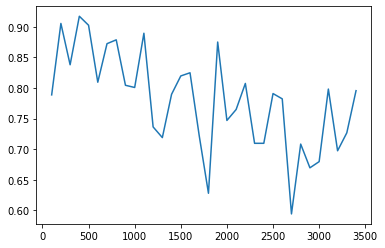

In [29]:
plt.figure()
plt.plot(iter_range,mean_f1, label='F1 change by number of features in LogisticRegression model')
plt.show()

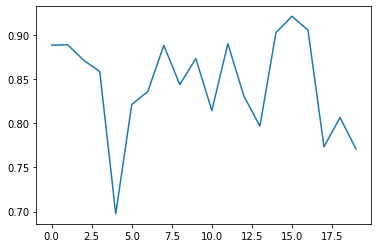

In [30]:
sup, n_ftrs, rank = get_n_most_important(700, X, Y)
f1s = []
for i in range(0,20):
  f1s.append(eval_and_print_metrics(LogisticRegression(), X[:, sup], Y))

plt.figure()
plt.plot(range(0,20), f1s, label='F1s for LogisticRegression model')
plt.show()

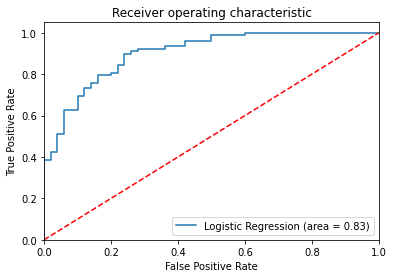

              precision    recall  f1-score   support

           0       0.84      0.74      0.79        50
           1       0.85      0.91      0.88        78

    accuracy                           0.84       128
   macro avg       0.84      0.83      0.83       128
weighted avg       0.84      0.84      0.84       128



In [34]:
fit_logreg_and_show_ROC(X[:, sup], Y, VALIDATION_SPLIT=0.2)